# **Project: Amazon Product Recommendation System**

----------------
## **Objective:**
----------------

The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 3.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-macosx_11_0_arm64.whl size=1091215 sha256=152de53c7de6f4b12af99abe96328069cc9a87a88f8e08800ac6e3e63279bd96
  Stored in directory: /Users/bryanmaruyama/Library/Caches/pip/wheels/f4/2b/26/e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**

In [4]:
dataframe = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ratings_Electronics.csv")
column_names = ['user_id', 'prod_id', 'rating', 'timestamp']

dataframe.columns = column_names
dataframe = dataframe.drop(['timestamp'], axis=1)

df = dataframe.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

In [5]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [6]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [7]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [8]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [9]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Check the number of rows and columns and provide observations.**

In [10]:
# Check the number of rows and columns and provide observations
df.shape

(125871, 3)

**Observation:**
There are 125871 rows and 3 columns.


### **Data types**

In [11]:
# Check Data types and provide observations
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Observations:** The user_id and prod_id are both objects, and the only purely numerical column is the rating. User_id is understandably an object because it includes numbers and characters, but prod_id I would think could be an integer.

### **Checking for missing values**

In [12]:
# Check for missing values present and provide observations
pd.DataFrame(data={'% of Missing Values':round(df.isna().sum()/df.isna().count()*100,2)}).sort_values(by='% of Missing Values',ascending=False)

,% of Missing Values
user_id,0.0
prod_id,0.0
rating,0.0


**Observation:** There is no missing data.

### **Summary Statistics**

In [13]:
# Summary statistics of 'rating' variable and provide observations
df['rating'].value_counts()

5.0    71034
4.0    32295
3.0    12060
2.0     5367
1.0     5115
Name: rating, dtype: int64

**Observations:** There seems to be more high ratings than low. It's also important to note that the minimum is 1, and not 0.

### **Checking the rating distribution**

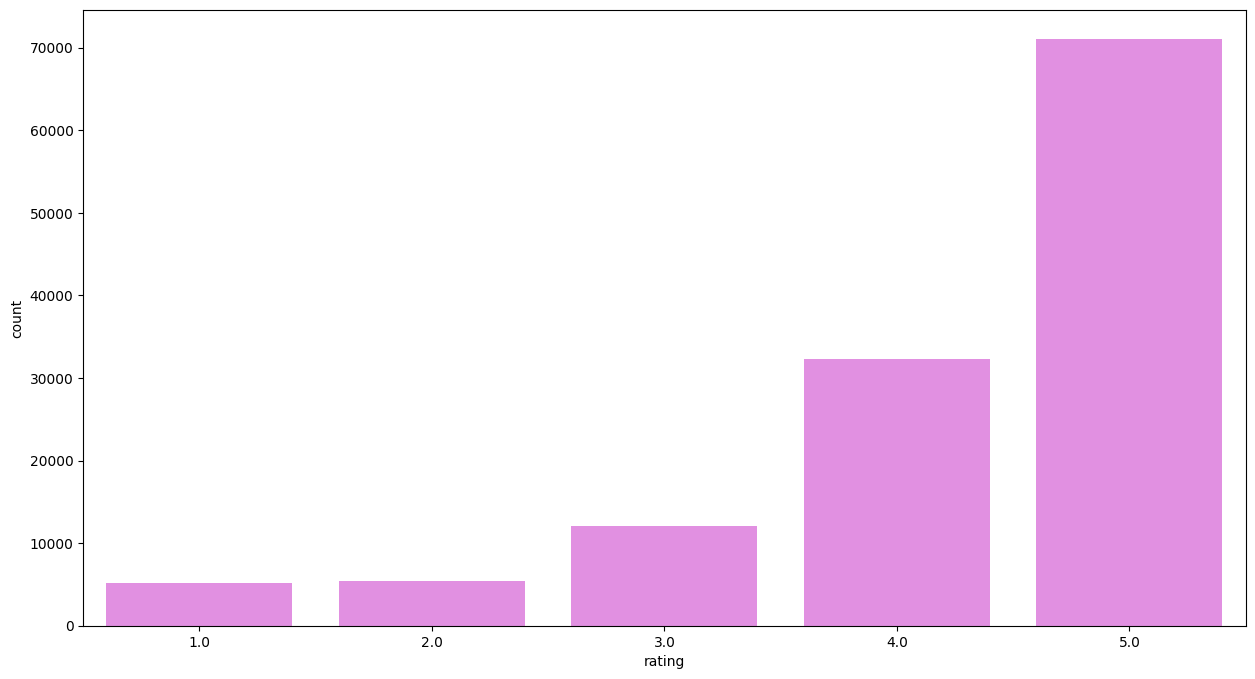

In [14]:
# Create the bar plot and provide observations
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='rating', color='violet')
plt.show()

**Observations:** The far majority of ratings are 5 stars, and it goes in descending order, so 4 stars has the next highest, then 3 and so on.


### **Checking the number of unique users and items in the dataset**

In [15]:
# Number of total rows in the data and number of unique user id and product id in the data
print("There are " + str(df['user_id'].nunique()) + " unique user ids.")
print("There are " + str(df['prod_id'].nunique()) + " unique product ids.")

There are 1540 unique user ids.
There are 48190 unique product ids.


In [16]:
df.shape

(125871, 3)

**Observations:** There are 1540 unique user_id's which means those 1540 users made all the purchases. There are 48190 unique prod_id's which means those 48190 products are the only products bought.

### **Users with the most number of ratings**

In [17]:
# Top 10 users based on the number of ratings
df['user_id'].value_counts().head(10)

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: user_id, dtype: int64

**Observations:** The most number of reviews a single user has is 520, and the 10th highest is 296. This is a fairly big range/jump from the top 10 reviewers.

## **Model 1: Rank Based Recommendation System**

In [18]:
# Average rating for each product
avg_rating = df.groupby('prod_id')['rating'].mean()
#print(avg_rating)
# Count of ratings for each product
r_count = df.groupby('prod_id')['rating'].count()
#print(r_count)
# Dataframe with calculated average and count of ratings
rating_df = pd.DataFrame({'avg_rating': avg_rating,
             'rating_count': r_count})

# Sorted dataframe by average of ratings in the descending order
rating_df = rating_df.sort_values(by='avg_rating', ascending=False)

# First five records of the "final_rating" dataset
rating_df.head(5)

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [19]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prods(df, n):
  return df.head(n)
# Finding products with minimum number of interactions
def min_interactions(df, min):
    result_df = df[df['rating_count'] >= min].sort_values(by='rating_count', ascending=True)
    return result_df

# Sorting values with respect to average rating
def sort_by_avg(df, n):
    sorted_df = df.sort_values(by='avg_rating', ascending=False)
    return sorted_df.head(5)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [20]:
sort_by_avg(min_interactions(rating_df, 50), 5)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [21]:
sort_by_avg(min_interactions(rating_df, 100), 5)

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using the `surprise` library to build the remaining models.

In [22]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [23]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [24]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [25]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True
               }

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)


# Fit the model on the training data
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user)

RMSE: 1.1089
Precision:  0.857
Recall:  0.516
F_1 score:  0.644


**Observations:**
- We can observe that the baseline model has RMSE=1.1089 on the test set.
- Intuition of Recall - We are getting a recall of ~0.52, which means out of all the similar products, 52% are recommended.
- Intuition of Precision - We are getting a precision of ~ 0.86, which means out of all the recommended products, 86% are relevant.
- Here F_1 score of the baseline model is ~0.64. It indicates that a little over half the recommended products were relevant.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [26]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observation:** We observe that the actual rating for this user-item rating is 5 and the predicted rating is 4.26 by this similarity based baseline model, which is pretty good, but not perfect.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [27]:
# Find unique user_id where prod_id is not equal to "1400501466"
unique_user_ids = df[df['prod_id'] != "1400501466"]['user_id'].unique()
print(unique_user_ids)

['A3BY5KCNQZXV5U' 'AT09WGFUM934H' 'A32HSNCNPRUMTR' ... 'AT53ZTTO707MB'
 'A1X3ESYZ79H59E' 'A328S9RN3U5M68']


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [28]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observation:** I'm still getting an estimated 4.26 score, so one possible situation is that there isn't enough related information to help the model determine for this specific user.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

In [29]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


1.0540065174694495
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [30]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized)


RMSE: 1.0563
Precision:  0.837
Recall:  0.504
F_1 score:  0.629


**Observations:**
- Our RSME measurement has now lowered by about 0.05.
- Every other metric, however, has slightly lowered.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [31]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict('A3LDPF5FMB782Z', 1400501466, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=None, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [32]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.264036591040643, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observation:** There is no difference from the baseline model, as the estimated value is still a 4.26 rating.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [33]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0, k=5)

[3, 4, 6, 8, 10]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [34]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [35]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
rating_df = df.copy()
recommendations = get_recommendations(rating_df, 'A3LDPF5FMB782Z', 5, similarity_algo_optimized)

In [36]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000VX6XL6,5
1,B001TH7GUU,5
2,B002JQNXZC,5
3,B00316263Y,5
4,B003ES5ZR8,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [37]:
# Reduce the dataset size
subset_data = Dataset.load_from_df(data.df.sample(frac=0.2, random_state=42), reader)

# Split the reduced dataset
trainset_subset, testset_subset = train_test_split(subset_data, test_size=0.3, random_state=42)

In [38]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False
               }

# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
algo_knn_item.fit(trainset_subset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(algo_knn_item, k=10)

RMSE: 1.0772
Precision:  0.82
Recall:  0.496
F_1 score:  0.618


**Observations:**
- We can observe that this  model has RMSE=1.0772 on the test set.
- Intuition of Recall - We are getting a recall of ~0.50, which means out of all the similar products, 50% are recommended.
- Intuition of Precision - We are getting a precision of ~ 0.82, which means out of all the recommended products, 82% are relevant.
- Here F_1 score of the baseline model is ~0.62. It indicates that a little over half the recommended products were relevant.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [39]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict('A3LDPF5FMB782Z', 1400501466, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.25   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=None, est=4.25322058906986, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observation:** There is an estimation of a 4.25 rating, which is slightly smaller than the 4.26 estimate we got from the previous user-user model.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [40]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.25   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.25322058906986, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observation:** We are still getting the same 4.25 estimated rating.

### **Hyperparameter tuning the item-item similarity-based model**

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(subset_data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Building the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [2]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=10, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset_subset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(similarity_algo_optimized_item)


NameError: name 'KNNBasic' is not defined

**Observations:**
- Our RMSE value decreased by 0.4 from our baseline model.
- The precision is slightly lower, however, at 82%.
- Our recall is also slightly worse at 49.6% compared to 51.6%.
- Our f_1 score also is 3% lower. at about 62%.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [43]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict('A3LDPF5FMB782Z', 1400501466, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.25   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=None, est=4.25322058906986, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [44]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.25   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.25322058906986, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations:** Both still have an expected rating of about 4.25 out of five. The baseline model had an expected output of 4.26, showing that they are still producing very similar results.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [45]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[1025, 1774, 2511, 2649, 5425]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [46]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
r_df_new = df.copy()
recommendations = get_recommendations(r_df_new, 'A3LDPF5FMB782Z', 5, similarity_algo_optimized_item)

In [47]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,0594451647,4.253221
1,0594481813,4.253221
2,0970407998,4.253221
3,0972683275,4.253221
4,1400532620,4.253221


### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [48]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.9901
Precision:  0.855
Recall:  0.503
F_1 score:  0.633


**Observations:**
- Our RSME is much lower than the baseline model at 0.9901.
- The precision is very close to the baseline at 85%.
- Our recall is slightly lower at 50%.
- And our F_1 score is also slighlty lower.
- Overall, our measurements are very good compared to our previous alternative models.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [49]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', 1400501466, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.11   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=None, est=4.1084942168719305, details={'was_impossible': False})

**Observation:** This is relatively much loewr than previous predictions; hoewver, it still remains in the 4 rating range at 4.11 instead of 4.25-4.26.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [50]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.52   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.516186265102144, details={'was_impossible': False})

**Observations:** This is relatively higher, estimating a rating of 4.52 which is higher than it's previously been.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [51]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.980244767141333
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [52]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2, random_state=1)

# Train the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.9846
Precision:  0.861
Recall:  0.51
F_1 score:  0.641


**Observations:**
- Our RSME is much lower than the baseline model at 0.9846.
- The precision beats our baseline at 86%.
- Our recall is barely lower at 51%.
- And our F_1 score is also slighlty lower at 64%.
- Overall, our measurements are very good compared even in comparison to our baseline and other variations.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [53]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', 1400501466, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=None, est=4.129347911019504, details={'was_impossible': False})

In [54]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.48   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.483738583668857, details={'was_impossible': False})

### **Conclusion and Recommendations**

In this case study, we built recommendation systems using four different algorithms:

- Rank-based using averages
- User-user similarity-based collaborative filtering
- Item-item similarity-based collaborative filtering
- Model-based (matrix factorization) collaborative filtering

The surprise library was used for each model besides the rank-based system. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data.

We used precision@k and recall@k as our precision metrics. From these, the F_1 score is calculated for each working model.

Overall, the optimized matrix factorization collaborative filtering recommendation system has given the best performance in terms of the F1-Score (~0.64)

Our optimized matrix factorization also has the lowest RMSE (0.9846) because it can account for latent factors as well. In fact, this model performed the best in precision at 86% as well. The only measurement metric it loses in is recall, but only by .006 against the baseline model.

If we had to choose a model out of the tested ones, the optimized matrix_factorization seems to be the overall best; however, we can try to further improve the performance of these models using hyperparameter tuning.

We can also try to combine different recommendation techniques to build a more complex model as a possible next step.